# Analisis Sentimen UU Cipta Kerja Menggunakan Algoritma Naive Bayes dan SVM

In [ ]:
# Import Modul Jcopml
!pip install jcopml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.8 MB/s eta 0:00:00
  Created wheel for jcopml: filename=jcopml-1.2.2-py2.py3-none-any.whl size=32194 sha256=8fe83a848a3d1b2e5cf50f57a1c0b079a86e8d60f2070b6528ab7d378a90c3e0
  Stored in directory: /root/.cache/pip/wheels/a6/1c/91/32f7a6b0a9d6bbcef17a7fc0d065f9a9b8d9904551b377b64d
Successfully built jcopml


In [ ]:
# Import Library
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Import Library
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.plot import plot_confusion_matrix,plot_classification_report,plot_roc_curve

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from jcopml.tuning import random_search_params as rsp
from jcopml.tuning import grid_search_params as gsp
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords

sw_indo = stopwords.words("indonesian")


### Import Data

In [ ]:
# Import Data
df = pd.read_excel("Stemming Label.xlsx", "Sheet1")
df

Stemming    Label  \
0                                       beli mixue haha  Positif   
1     mixue buka cabang bar eh maksud open commis bg...  Positif   
2     day canon constellation modern lokalisasi au t...  Positif   
3     biasa bandung mixue paket pas diri allahuakbar...  Positif   
4     rencana beli mixue sempol nya beli sempol wkwk...   Netral   
...                                                 ...      ...   
6740          wi beli seblak mixue mending lu sonoh wkw  Positif   
6741                     yuk uujan yuk pergi beli mixue   Netral   
6742  kemarin malam beli mixue rest area untung bobanya  Positif   
6743  bm mcd mixue alhamdulillah keturutaan hihi btw...  Positif   
6744                  botol minum sih gemoy mixue rbuan   Netral   

               LABEL 7P  
0               Product  
1                 Place  
2                 Place  
3               Process  
4               Product  
...                 ...  
6740            Product  
6741            Product  
6742              Place  
6743            Product  
6744  Physical Evidence  

[6745 rows x 3 columns]

In [ ]:
# Hapus Data Duplikat
df.drop_duplicates(subset=["Stemming"], keep="first", inplace=True)
df

Stemming    Label  \
0                                       beli mixue haha  Positif   
1     mixue buka cabang bar eh maksud open commis bg...  Positif   
2     day canon constellation modern lokalisasi au t...  Positif   
3     biasa bandung mixue paket pas diri allahuakbar...  Positif   
4     rencana beli mixue sempol nya beli sempol wkwk...   Netral   
...                                                 ...      ...   
6740          wi beli seblak mixue mending lu sonoh wkw  Positif   
6741                     yuk uujan yuk pergi beli mixue   Netral   
6742  kemarin malam beli mixue rest area untung bobanya  Positif   
6743  bm mcd mixue alhamdulillah keturutaan hihi btw...  Positif   
6744                  botol minum sih gemoy mixue rbuan   Netral   

               LABEL 7P  
0               Product  
1                 Place  
2                 Place  
3               Process  
4               Product  
...                 ...  
6740            Product  
6741            Product  
6742              Place  
6743            Product  
6744  Physical Evidence  

[6745 rows x 3 columns]

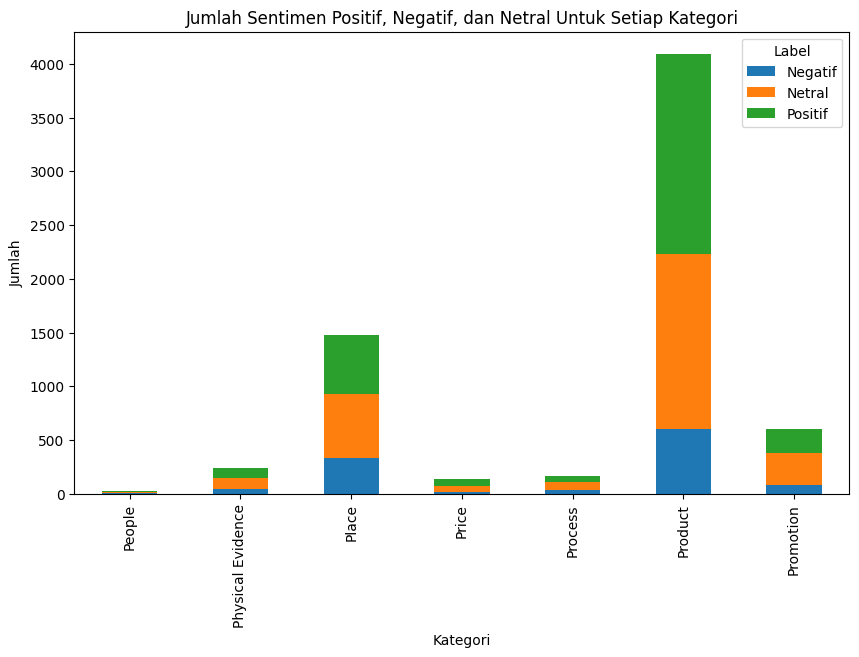

In [ ]:
# Group by 'LABEL 7P' and 'Label'
grouped = df.groupby(['LABEL 7P', 'Label']).size().reset_index(name='count')

# Pivot table
pivot_table = grouped.pivot(index='LABEL 7P', columns='Label', values='count')

# Visualisasi dengan stacked bar chart
pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Jumlah Sentimen Positif, Negatif, dan Netral Untuk Setiap Kategori')
plt.xlabel('Kategori')
plt.ylabel('Jumlah')
plt.show()

In [ ]:
# Melihat perbandingan sentimen dalam bentuk pivot tabel
pivot_table

Label              Negatif  Netral  Positif
LABEL 7P                                   
People                   5       9       15
Physical Evidence       40     105       97
Place                  328     599      548
Price                   17      57       62
Process                 36      71       58
Product                605    1630     1860
Promotion               82     293      228

In [ ]:
# menghitung jumlah sentimen positif, negatif
jumlah_positif = len(df[df['Label'] == 'Positif'])
jumlah_negatif = len(df[df['Label'] == 'Negatif'])
jumlah_netral = len(df[df['Label'] == 'Negatif'])
print("Jumlah Sentiment Positif:", jumlah_positif)
print("Jumlah Sentiment Negatif:", jumlah_negatif)
print("Jumlah Sentiment Netral:", jumlah_netral)

Jumlah Sentiment Positif: 2868
Jumlah Sentiment Negatif: 1113
Jumlah Sentiment Netral: 1113


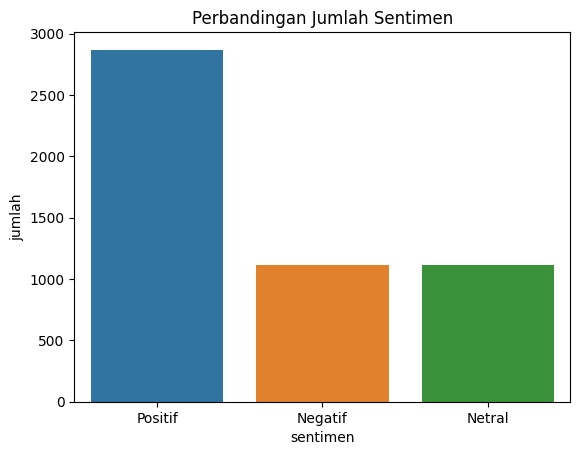

In [ ]:
# membuat dataframe untuk data jumlah sentimen
df1 = pd.DataFrame({'sentimen': ['Positif', 'Negatif', 'Netral'],
                   'jumlah': [jumlah_positif, jumlah_negatif, jumlah_netral]})

# membuat grafik bar menggunakan seaborn
sns.barplot(x='sentimen', y='jumlah', data=df1)

# menambahkan judul pada grafik
plt.title('Perbandingan Jumlah Sentimen')

# menampilkan grafik
plt.show()


In [ ]:
# Membuat Grafik persentase
fig = px.pie(df, names='Label', title = 'Persentase Label Sentiment')
fig.update_layout(title={'x':0.5, 'y':0.95, 'xanchor':'center', 'yanchor':'top'})
fig.show()

In [ ]:
# Membuat Grafik persentase
fig = px.pie(df, names='LABEL 7P', title = 'Persentase Kategori 7P')
fig.update_layout(title={'x':0.5, 'y':0.95, 'xanchor':'center', 'yanchor':'top'})
fig.show()

Text(0, 0.5, 'Jumlah')

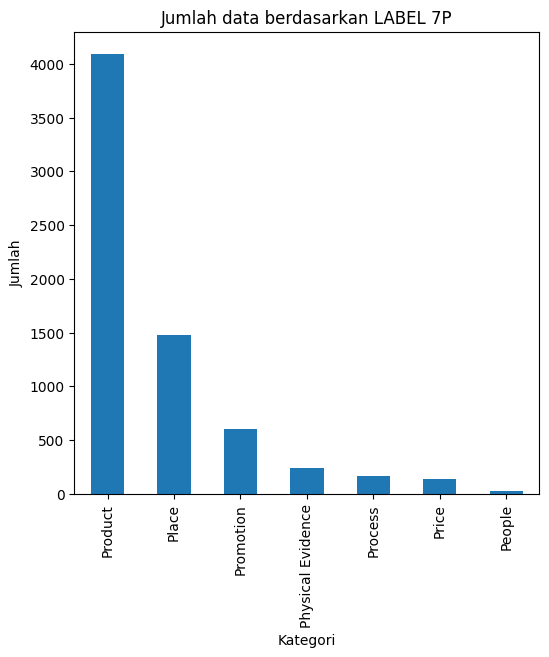

In [ ]:
# menghitung jumlah kategori dalam kolom 'LABEL 7P'
count = df['LABEL 7P'].value_counts()

# membuat plot
fig, ax = plt.subplots(figsize=(6, 6)) # figsize dengan ukuran 6x6
count.plot(kind='bar', ax=ax)

# memberikan judul plot dan label sumbu x dan y
ax.set_title('Jumlah data berdasarkan LABEL 7P')
ax.set_xlabel('Kategori')
ax.set_ylabel('Jumlah')

In [ ]:
# Jumlah data berdasarkan LABEL 7P
count

Product              4095
Place                1475
Promotion             603
Physical Evidence     242
Process               165
Price                 136
People                 29
Name: LABEL 7P, dtype: int64

### Top 10 Word in Category

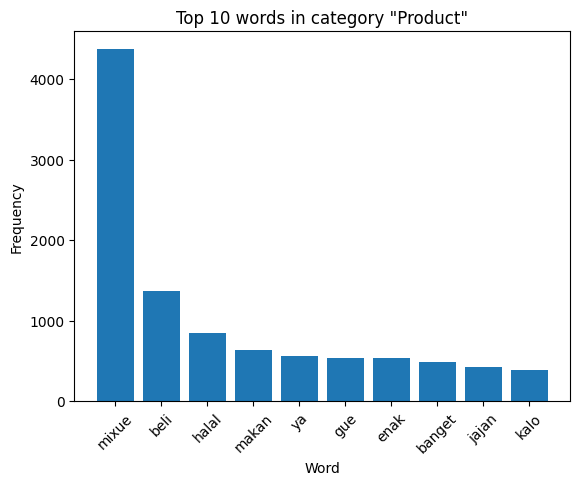

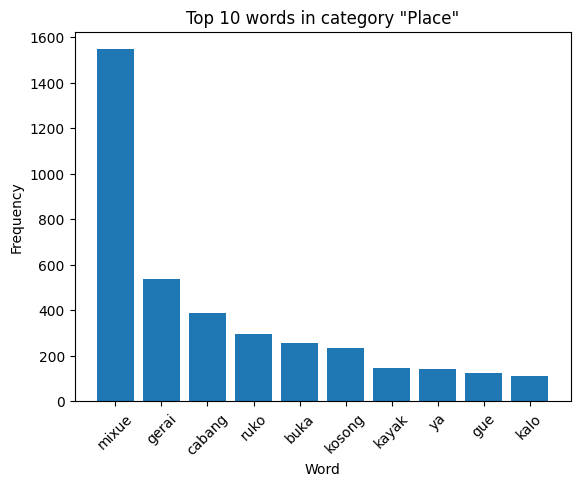

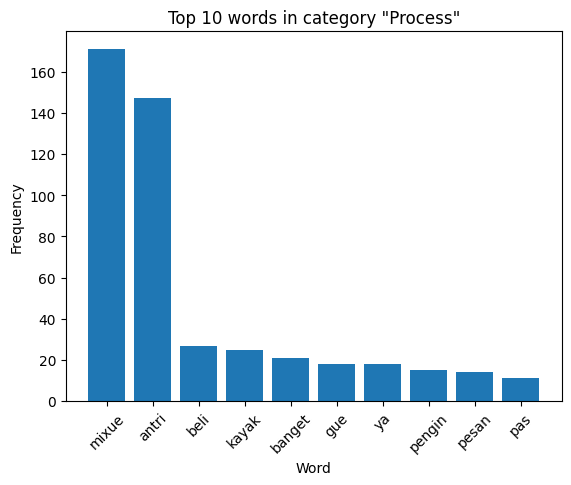

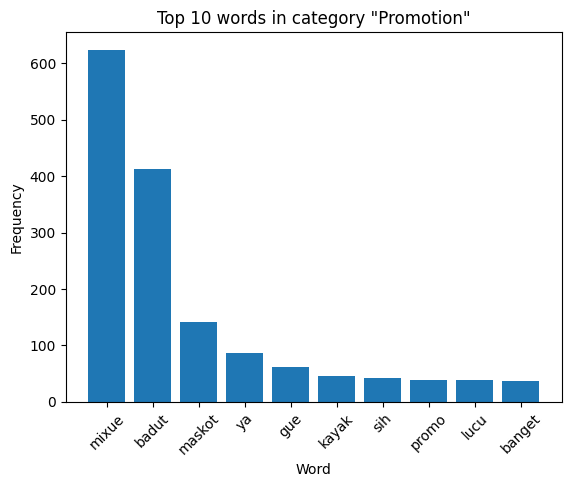

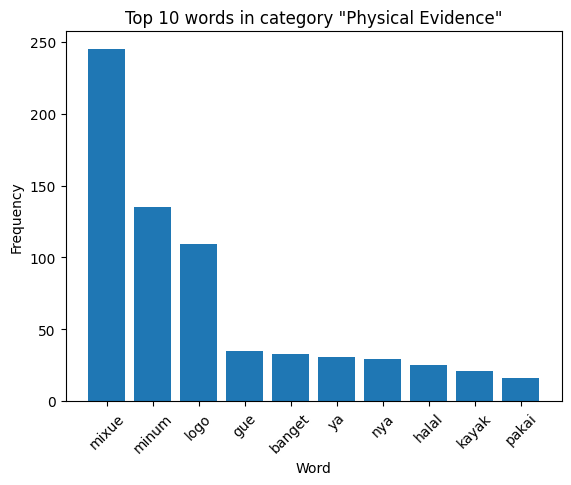

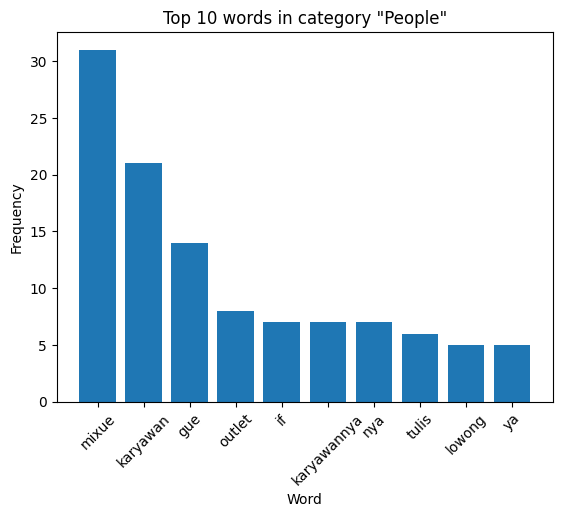

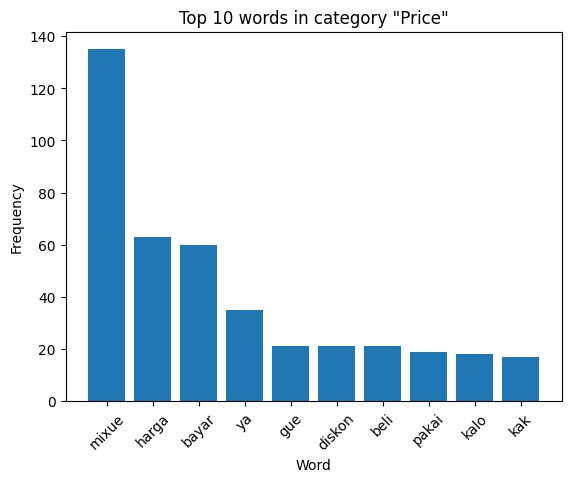

In [ ]:
# define count vectorizer with analyzer function to stem the words
count_vect = CountVectorizer(analyzer='word')

# create empty dictionary to store the most common words
top_words = {}

# loop through each category in LABEL 7P
for category in df['LABEL 7P'].unique():
    # filter the dataframe by category
    subset = df[df['LABEL 7P']==category]
    # fit and transform the count vectorizer on the 'stemming' column
    word_counts = count_vect.fit_transform(subset['Stemming'])
    # get the feature names from the count vectorizer
    feature_names = count_vect.get_feature_names_out()
    # sum the counts of each word in the vocabulary
    word_count = word_counts.sum(axis=0)
    # create a dictionary of word frequencies
    word_freq = {word: word_count[0, idx] for word, idx in count_vect.vocabulary_.items()}
    # sort the dictionary by frequency and take the top 10
    top_words[category] = dict(Counter(word_freq).most_common(10))

# plot the bar chart for each category
for category, words in top_words.items():
    plt.bar(words.keys(), words.values())
    plt.title(f'Top 10 words in category "{category}"')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

### Wordcloud

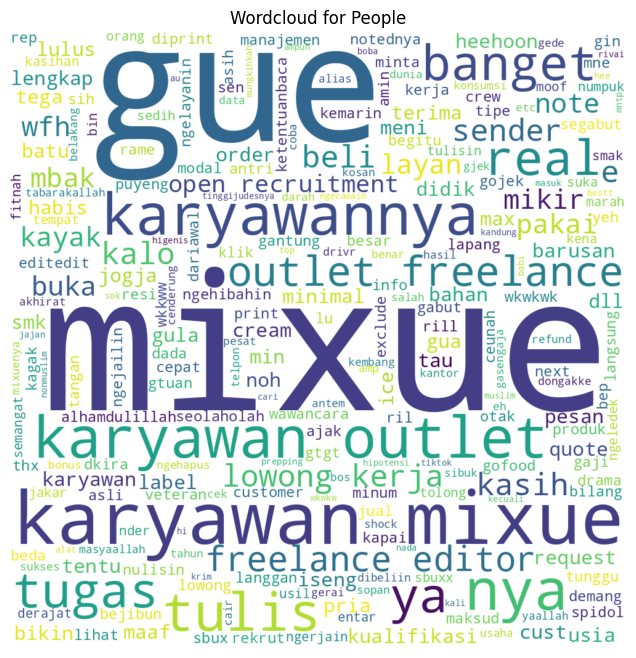

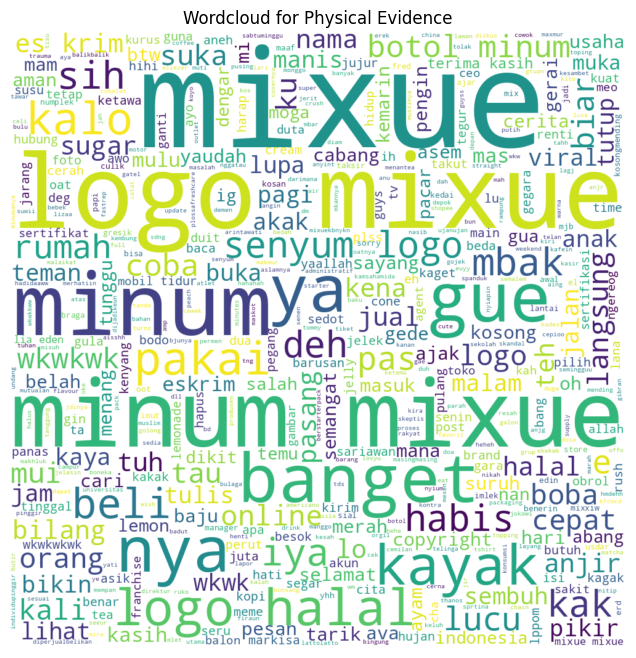

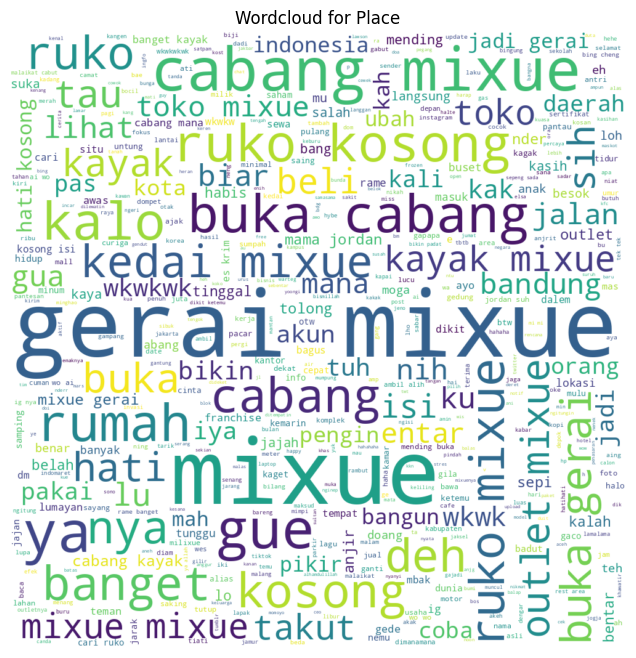

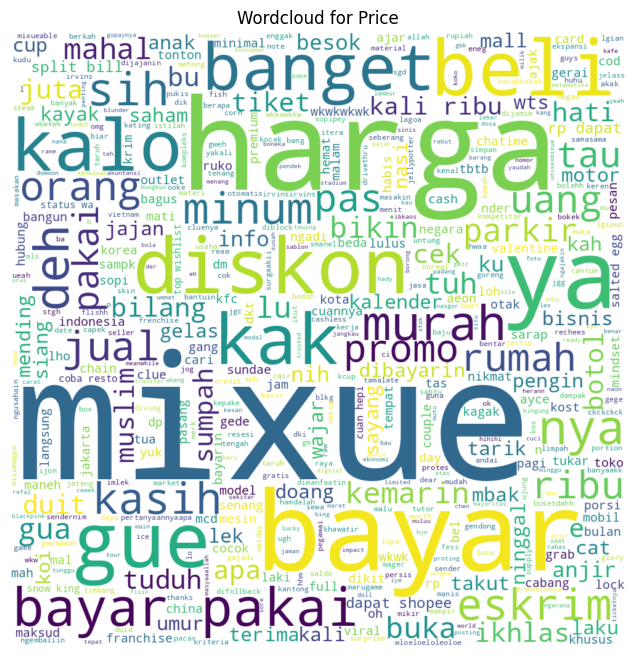

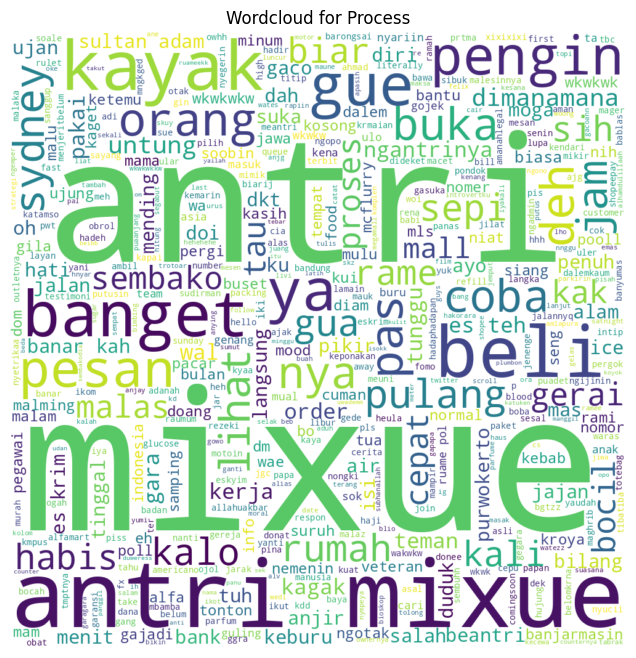

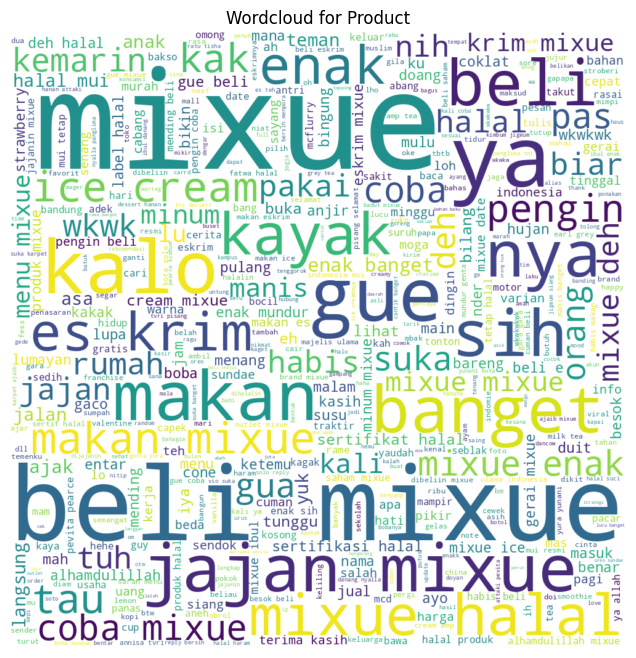

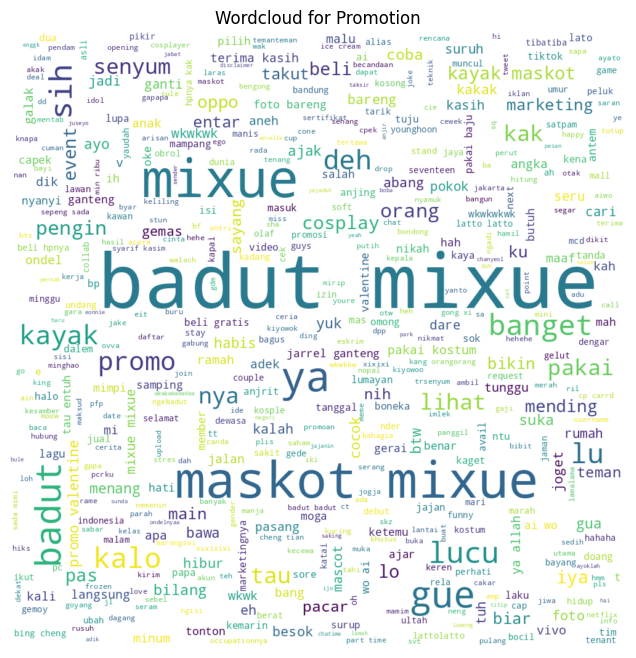

In [ ]:

# define categories
categories = ['People', 'Physical Evidence', 'Place', 'Price', 'Process', 'Product', 'Promotion']

# create a wordcloud for each category
for category in categories:
    # subset data based on category
    subset = df[df['LABEL 7P'] == category]
    # join all text in subset into one string
    text = ' '.join(subset['Stemming'])
    # generate wordcloud
    wordcloud = WordCloud(width=1000, height=1000, background_color='white', max_words=500, colormap='viridis').generate(text)
    # plot wordcloud
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Wordcloud for {category}")
    plt.show()


### Klasifikasi dengan SVM

In [ ]:
# drop rows with missing values
df = df.dropna()

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Stemming'], df['Label'], test_size=0.2, random_state=42)

# define parameters for grid search
param_grid = {
    'tfidf__max_df': [0.25, 0.5],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# define pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=word_tokenize, stop_words=sw_indo)),
    ('svm', SVC())
])

# perform grid search and fit pipeline on each category
categories = ['People', 'Physical Evidence', 'Place', 'Price', 'Process', 'Product', 'Promotion']
for cat in categories:
    # filter data by category
    X_train_cat = X_train[df['LABEL 7P'] == cat]
    y_train_cat = y_train[df['LABEL 7P'] == cat]
    X_test_cat = X_test[df['LABEL 7P'] == cat]
    y_test_cat = y_test[df['LABEL 7P'] == cat]

    if len(X_train_cat) > 0:  # check if there are samples in the filtered dataset
        # perform grid search
        grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=10, n_jobs=-1, scoring='f1_micro')
        grid_search.fit(X_train_cat, y_train_cat)

        # get best parameters and fit pipeline on training data
        best_params = grid_search.best_params_
        pipeline.set_params(**best_params)
        pipeline.fit(X_train_cat, y_train_cat)

        # predict on test data and calculate evaluation metrics
        y_pred = pipeline.predict(X_test_cat)
        acc = accuracy_score(y_test_cat, y_pred)
        f1 = f1_score(y_test_cat, y_pred, average='weighted')
        precision = precision_score(y_test_cat, y_pred, average='weighted')
        recall = recall_score(y_test_cat, y_pred, average='weighted')

        # print confusion matrix and evaluation metrics for the category
        print(f'Confusion matrix for category "{cat}":\n')
        print(confusion_matrix(y_test_cat, y_pred))
        print(classification_report(y_test_cat, y_pred))
        print(f'Accuracy: {acc:.4f}, F1 score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}\n')
    else:
        print(f'No samples found for category "{cat}"')



/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=10.

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



Confusion matrix for category "People":

[[1 0 0]
 [0 2 2]
 [0 0 2]]
              precision    recall  f1-score   support

     Negatif       1.00      1.00      1.00         1
      Netral       1.00      0.50      0.67         4
     Positif       0.50      1.00      0.67         2

    accuracy                           0.71         7
   macro avg       0.83      0.83      0.78         7
weighted avg       0.86      0.71      0.71         7

Accuracy: 0.7143, F1 score: 0.7143, Precision: 0.8571, Recall: 0.7143



/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being 

Confusion matrix for category "Physical Evidence":

[[ 0  2  3]
 [ 0 20  6]
 [ 0  5  7]]
              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00         5
      Netral       0.74      0.77      0.75        26
     Positif       0.44      0.58      0.50        12

    accuracy                           0.63        43
   macro avg       0.39      0.45      0.42        43
weighted avg       0.57      0.63      0.60        43

Accuracy: 0.6279, F1 score: 0.5959, Precision: 0.5700, Recall: 0.6279



/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



Confusion matrix for category "Place":

[[ 31  21  19]
 [  5 111  22]
 [ 10  46  46]]
              precision    recall  f1-score   support

     Negatif       0.67      0.44      0.53        71
      Netral       0.62      0.80      0.70       138
     Positif       0.53      0.45      0.49       102

    accuracy                           0.60       311
   macro avg       0.61      0.56      0.57       311
weighted avg       0.60      0.60      0.59       311

Accuracy: 0.6045, F1 score: 0.5924, Precision: 0.6040, Recall: 0.6045



/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being 

Confusion matrix for category "Price":

[[0 1 3]
 [0 6 4]
 [0 2 6]]
              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00         4
      Netral       0.67      0.60      0.63        10
     Positif       0.46      0.75      0.57         8

    accuracy                           0.55        22
   macro avg       0.38      0.45      0.40        22
weighted avg       0.47      0.55      0.49        22

Accuracy: 0.5455, F1 score: 0.4949, Precision: 0.4709, Recall: 0.5455



/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



Confusion matrix for category "Process":

[[2 3 5]
 [1 6 0]
 [2 3 3]]
              precision    recall  f1-score   support

     Negatif       0.40      0.20      0.27        10
      Netral       0.50      0.86      0.63         7
     Positif       0.38      0.38      0.38         8

    accuracy                           0.44        25
   macro avg       0.42      0.48      0.42        25
weighted avg       0.42      0.44      0.40        25

Accuracy: 0.4400, F1 score: 0.4035, Precision: 0.4200, Recall: 0.4400



/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



Confusion matrix for category "Product":

[[ 43  32  50]
 [ 10 281  59]
 [  5  92 251]]
              precision    recall  f1-score   support

     Negatif       0.74      0.34      0.47       125
      Netral       0.69      0.80      0.74       350
     Positif       0.70      0.72      0.71       348

    accuracy                           0.70       823
   macro avg       0.71      0.62      0.64       823
weighted avg       0.70      0.70      0.69       823

Accuracy: 0.6987, F1 score: 0.6878, Precision: 0.7025, Recall: 0.6987



/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



Confusion matrix for category "Promotion":

[[ 1  6  3]
 [ 3 45 15]
 [ 2 19 24]]
              precision    recall  f1-score   support

     Negatif       0.17      0.10      0.12        10
      Netral       0.64      0.71      0.68        63
     Positif       0.57      0.53      0.55        45

    accuracy                           0.59       118
   macro avg       0.46      0.45      0.45       118
weighted avg       0.58      0.59      0.58       118

Accuracy: 0.5932, F1 score: 0.5823, Precision: 0.5753, Recall: 0.5932



In [ ]:
models = grid_search.classes_
models

array(['Negatif', 'Netral', 'Positif'], dtype=object)

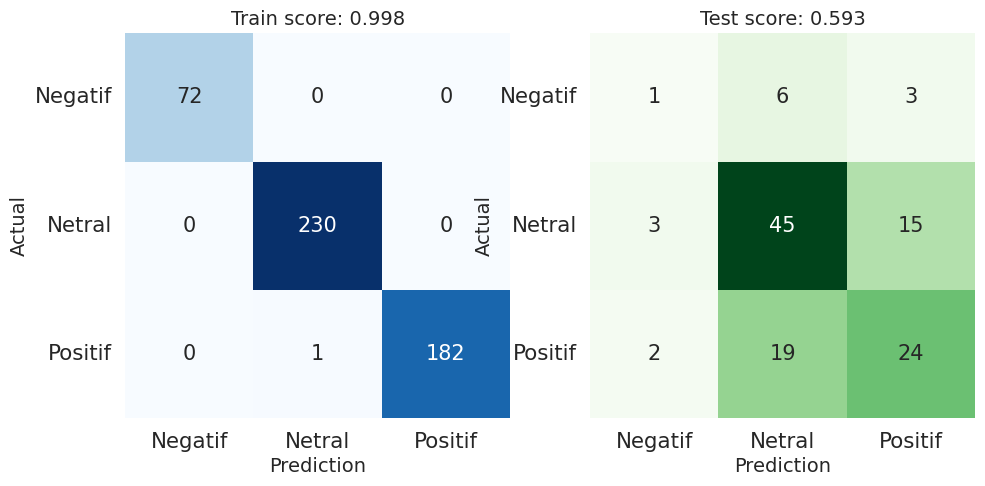

In [ ]:
plot_confusion_matrix(X_train_cat, y_train_cat, X_test_cat, y_test_cat, pipeline)